In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

import os
import gc

from tqdm import tqdm
from pathlib import Path


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('❌CUDA is not available.  Training on CPU ...')
else:
    print('✔️CUDA is available!  Training on GPU ...')

✔️CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/NIR/data/images/train.zip
!unzip -q /content/gdrive/MyDrive/NIR/data/images/test.zip

In [5]:
IMAGES_DIR = Path("train/")
TEST_IMAGES_DIR = Path("test/")
DEVICE = torch.device("cuda")

In [6]:
print(os.listdir(IMAGES_DIR))
print(os.listdir(TEST_IMAGES_DIR))

['9.jpg', '3.jpg', '10.jpg', '1.jpg', '5.jpg', '8.jpg', '2.jpg', '6.jpg', '7.jpg', '4.jpg']
['3.jpg', '1.jpg', '5.jpg', '2.jpg', '4.jpg']


In [7]:
def add_noise(image, scale=0.2707):
    noise = np.random.rayleigh(scale=scale, size=image.size)
    # Add noise
    noised_img = image + image * noise
    noised_img = np.where(noised_img <= 255, noised_img, 255)
    return noised_img

In [8]:
RESCALE_SIZE = 608

class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images_list = os.listdir(self.image_dir)

        self.x_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(add_noise),
            # transforms.Normalize(0.5, 0.5),
            transforms.Lambda(lambda x: x / 255),
            transforms.ToTensor(),
        ])
        self.y_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_dir / self.images_list[index])
        noised_image = self.x_transform(image).float()
        image = self.y_transform(image)

        return noised_image, image

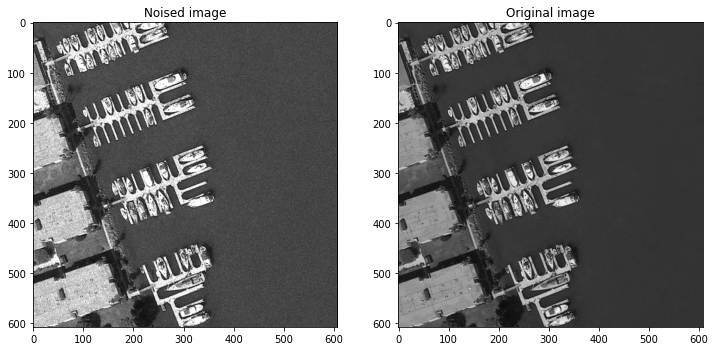

In [9]:
image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for X, y in image_loader:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    # fig.figsize(12, 12)
    ax1.imshow(X[0][0], cmap="gray")
    ax1.set_title("Noised image")
    ax2.imshow(y[0][0], cmap="gray")
    ax2.set_title("Original image")
    break

# UNet (modification)

In [28]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.bn(self.relu(self.conv(x)))

In [27]:
class DoublConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, **kwargs)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, **kwargs)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        block_1 = self.bn1(self.relu1(self.conv1(x)))
        block_2 = self.bn2(self.relu2(self.conv2(block_1)))
        return block_2

In [43]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = DoublConv(1, 64)
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv1 = DoublConv(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv2 = DoublConv(128, 256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = DoublConv(256, 512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(DoublConv(512, 1024), 
                                             nn.Conv2d(1024, 1024, 1))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec_conv0 = DoublConv(1024, 512)
        
        self.upsample1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec_conv1 = DoublConv(512, 256)
        
        self.upsample2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec_conv2 = DoublConv(256, 128)

        self.upsample3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec_conv3 = nn.Sequential(DoublConv(128, 64),
                                       nn.Conv2d(64, 1, 1))


    def _crop_concat(self, master, slave):
        _, _, H, W = master.shape
        slave = transforms.CenterCrop([H, W])(slave)
        return torch.cat([master, slave], 1)


    def forward(self, x):
        # x = nn.functional.pad(x, (94,)*4, mode="reflect")

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool0(e1))
        e3 = self.enc_conv3(self.pool0(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))
    
        # decoder
        d0 = self.dec_conv0(self._crop_concat(self.upsample0(b), e3))
        d1 = self.dec_conv1(self._crop_concat(self.upsample1(d0), e2))
        d2 = self.dec_conv2(self._crop_concat(self.upsample2(d1), e1))
        d3 = self.dec_conv3(self._crop_concat(self.upsample3(d2), e0))
        return d3

In [44]:
learning_rate = 0.005
EPOCHES = 15
BATCH_SIZE = 2
NUM_FILTERS = 3

image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = UNet().to(device=DEVICE)

In [45]:
def train(image_loader, model):

    # criterion = nn.L1Loss(reduction='mean')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    losses = []
    ssim_list = []
    for epoch in tqdm(range(EPOCHES)):
        for X, y in image_loader:
            X = X.to(device=DEVICE)
            y = y.to(device=DEVICE)

            output = model(X)
            # loss = torch.sqrt(criterion(output, y))
            loss = criterion(output, y)

            losses.append(loss.to("cpu").item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # return 1, 2

            for out, y in zip(output, y):
                image = out[0]
                target = y[0]
                ssim_list.append(ssim(image.detach().cpu().numpy(), target.detach().cpu().numpy()))
        scheduler.step()
                
        # print(loss)
    return losses, ssim_list


In [46]:
losses, ssim_list = train(image_loader, model)

100%|██████████| 15/15 [01:01<00:00,  4.08s/it]


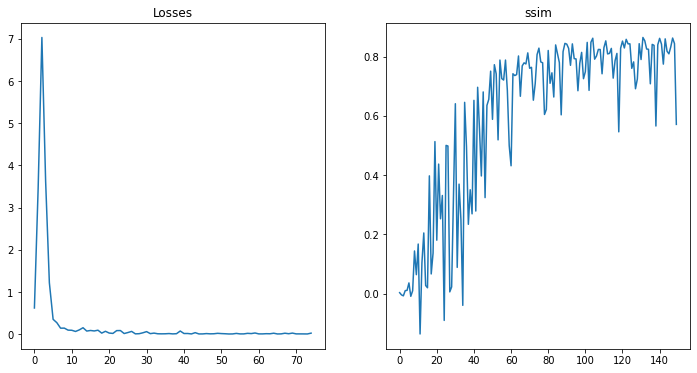

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(ssim_list)
ax[1].set_title("ssim");


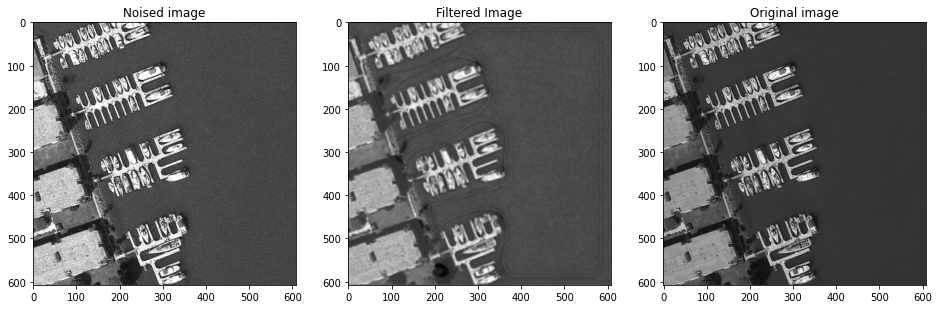

In [55]:
image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    model.eval()
    for X, y in image_loader:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))

        filtered_image = model(X.to(DEVICE)).cpu()
        ax2.imshow(filtered_image[0][0], cmap="gray")
        ax2.set_title("Filtered Image")


        ax1.imshow(X[0][0], cmap="gray")
        ax1.set_title("Noised image")

        ax3.imshow(y[0][0], cmap="gray")
        ax3.set_title("Original image")
        break

In [42]:
gc.collect()
del model
torch.cuda.empty_cache()
